In [1]:
import pandas as pd
import numpy as np
import random
import torch
import time
import sys
import re
import os

!pip install demoji
import demoji
demoji.download_codes()

!pip install greek-stemmer-pos
from greek_stemmer import stemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import  cross_val_score, train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

%pip install torchmetrics

# torch
import torch
import torch.cuda
import torch.nn as nn
import torch.backends.cudnn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from torchmetrics import ConfusionMatrix
from torchmetrics.functional import f1_score

def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
        This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

device = 'cpu'
print('Working on:', device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.4 MB/s eta 0:00:00


/tmp/ipykernel_18/709129067.py:12: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.0/234.0 kB 6.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Working on: cpu


## Read Files & Extract Information

In [2]:
# paths
TrainSet_File = '/kaggle/input/ys19-2023-assignment-3/train_set.csv'
ValidSet_File = '/kaggle/input/ys19-2023-assignment-3/valid_set.csv'
TestSet_File = '/kaggle/input/ys19-2023-assignment-3/test_set.csv'
GreekStopWords_File = '/kaggle/input/greekstopwords-ass3/stopwords-el.csv'

# read files (train, validation and test set) and save them in dataframes
dataframe_TrainSet = pd.read_csv(TrainSet_File, sep=',')
dataframe_ValidSet = pd.read_csv(ValidSet_File, sep=',')
dataframe_TestSet = pd.read_csv(TestSet_File, sep=',')

# read GreekStopWords_File and save this in dataframe
dataframe_GreekStopWords = pd.read_csv(GreekStopWords_File, sep=' ')
GreekStopWordsList =  list(dataframe_GreekStopWords["string"])
#GreekStopWordsList

$ $

$ \bullet $  $ $ $ $ Training Set

In [3]:
dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,#απολυμανση_κοριοι #απεντομωση_κοριος #απολυμα...,NEUTRAL,SYRIZA
1,9531,Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη...,NEGATIVE,ND
2,14146,"Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στου...",POSITIVE,KKE
3,28716,@five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25...,NEUTRAL,KKE
4,32886,@ai_katerina Αυτό που είναι συγκλονιστικό είνα...,NEUTRAL,SYRIZA


$ $

$ \bullet $  $ $ $ $ Validation Set

In [4]:
dataframe_ValidSet.head()

,New_ID,Text,Sentiment,Party
0,435,@GLinard @teza_tereza @AdonisGeorgiadi @atsipr...,POSITIVE,SYRIZA
1,3061,Τσίπρας: Ζητήσαμε και από την αντιπολίτευση να...,NEGATIVE,SYRIZA
2,2161,"Ο σωστος ο Ελληνας, ο δημοκρατης, ο Ελληνας το...",NEGATIVE,ND
3,1271,@30__kai Ναι βλέπεις αυτά ενδιαφέρουν τους Μητ...,POSITIVE,ND
4,4396,Η συνέντευξη Μητσοτάκη στον Alpha: Υπό αίρεση ...,NEUTRAL,ND


$ $

$ \bullet $  $ $ $ $ Test Set

In [5]:
dataframe_TestSet.head()

,New_ID,Text,Party
0,1,Ο Κυριάκος Μητσοτάκης δεν ξέρει που είναι το Μ...,ND
1,2,Συνέντευξη της υποψήφιας βουλευτή με τη Νέα Δη...,ND
2,3,Σε αυτές τις εκλογές οι μαθητές και οι φοιτητέ...,KKE
3,4,Γεννηματά: Το ΚΙΝΑΛ δεν θα γίνει δεκανίκι κανε...,PASOK
4,5,"Την Κυριακή των εκλογών, Οκτώβρης 1993, ξημερώ...",ND


## Data processing and Analysis

####  Pre-processing

##### **1**. $ $  **Data Cleaning**

$ \bullet$ $ $ Auxiliary functions for Data Cleaning

In [6]:
# 1. Remove URLs
def remove_URLS(ww):
    w1 = ""

    word_list = ww.split()
    for word in word_list:
        if len(word) > 8:
            auxilary_str = word[:8]
            if auxilary_str == "https://":
                continue

        w1 += word
        w1 += " "

    return w1


# 2. Remove Hashtags
def remove_Hashtags(ww):
    w1 = ""
    
    word_list = ww.split()
    for word in word_list:
        auxilary_str = word[:1]
        if auxilary_str == "#":
            continue
        else:
            w1 += word
            w1 += " "

    return w1


# 3. Remove Tags
def remove_Tags(ww):
    w1 = ""

    word_list = ww.split()
    for word in word_list:
        auxilary_str = word[:1]
        if auxilary_str == "@":
            continue
        else:
            w1 += word
            w1 += " "

    return w1


# 4. Remove Symbols
def remove_symbols(ww):

    w1 = ""

    for c in ww:

        if c in ['+', '-', ':', '(', ')', '[', ']', '{', '}', '!',
                 '?', '$', '%', '^', '&', '*', '~', '\;', '«', '»',
                 '.', '`', '=', '#', '@', ']', '|', '‘', '、', ',',
                 '。', '”', '\'', '"']:
            w1 += ' '
        elif c == '_':
            w1 += ' '
        else:
            w1 += c

    return w1


# 5. Remove Emojis
def remove_emoji(ww):
    emoji_list = demoji.findall(ww)
    for emoji in emoji_list:
        ww = re.sub(emoji, ' ', ww)

    return ww

# 6. Remove Numbers
def remove_numbers(string):
    string = re.sub(r"\d+",' ' , string)
    return string


$\bullet $  $  $  Data Cleaning

In [7]:
def data_cleaning(text):

    text = remove_URLS(text)
    text = remove_Hashtags(text)
    text = remove_Tags(text)
    text = remove_symbols(text)
    text = remove_emoji(text)
    text = remove_numbers(text)
    
    return text

dataframe_TrainSet['Text'] = dataframe_TrainSet.apply(lambda row: data_cleaning(row['Text']), axis=1)
dataframe_ValidSet['Text'] = dataframe_ValidSet.apply(lambda row: data_cleaning(row['Text']), axis=1)
dataframe_TestSet['Text'] = dataframe_TestSet.apply(lambda row: data_cleaning(row['Text']), axis=1)

dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,Κυριακη Κοριοί απολύμανση Καταπολέμηση κοριώ...,NEUTRAL,SYRIZA
1,9531,Έξι νέες επιστολές για τη Μακεδονία καίνε τη...,NEGATIVE,ND
2,14146,Ισχυρό ΚΚΕ δύναμη του λαού στη Βουλή και στου...,POSITIVE,KKE
3,28716,Μνημονιακότατο το,NEUTRAL,KKE
4,32886,Αυτό που είναι συγκλονιστικό είναι η ψυχασθένε...,NEUTRAL,SYRIZA


##### **2**. $ $ **Simplification**

In [8]:
# convert all the letters to lowercase
def lowercase(string):
    string2 = string.lower()
    return string2

dataframe_TrainSet['Text'] = dataframe_TrainSet.apply(lambda row: lowercase(row['Text']), axis=1)
dataframe_ValidSet['Text'] = dataframe_ValidSet.apply(lambda row: lowercase(row['Text']), axis=1)
dataframe_TestSet['Text'] = dataframe_TestSet.apply(lambda row: lowercase(row['Text']), axis=1)

dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,κυριακη κοριοί απολύμανση καταπολέμηση κοριώ...,NEUTRAL,SYRIZA
1,9531,έξι νέες επιστολές για τη μακεδονία καίνε τη...,NEGATIVE,ND
2,14146,ισχυρό κκε δύναμη του λαού στη βουλή και στου...,POSITIVE,KKE
3,28716,μνημονιακότατο το,NEUTRAL,KKE
4,32886,αυτό που είναι συγκλονιστικό είναι η ψυχασθένε...,NEUTRAL,SYRIZA


$ $

##### **3**. $ $ **StopWords**

In [9]:
# remove stop words
dataframe_TrainSet['Text'] = dataframe_TrainSet['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (GreekStopWordsList)]))
dataframe_ValidSet['Text'] = dataframe_ValidSet['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (GreekStopWordsList)]))
dataframe_TestSet['Text'] = dataframe_TestSet['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (GreekStopWordsList)]))

dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,κυριακη κοριοί απολύμανση καταπολέμηση κοριών ...,NEUTRAL,SYRIZA
1,9531,έξι νέες επιστολές μακεδονία καίνε νδ μητσοτάκ...,NEGATIVE,ND
2,14146,ισχυρό κκε δύναμη λαού βουλή καθημερινούς αγώνες,POSITIVE,KKE
3,28716,μνημονιακότατο,NEUTRAL,KKE
4,32886,αυτό είναι συγκλονιστικό είναι ψυχασθένεια τσίπρα,NEUTRAL,SYRIZA


$ $

##### **4**. $ $ **Stemming**

In [10]:
# conversion of words into a common root
def Stemmer(ww):
    w1 = ""
    count = 0
    
    word_list = ww.split()
    for word in word_list:
        
        w1 += stemmer.stem_word(word, 'VBG')
        if (len(word_list) - 1) != count:
            w1 += " "
        
        count = count + 1
    
    return w1

dataframe_TrainSet['Text'] = dataframe_TrainSet.apply(lambda row: Stemmer(row['Text']), axis=1)
dataframe_ValidSet['Text'] = dataframe_ValidSet.apply(lambda row: Stemmer(row['Text']), axis=1)
dataframe_TestSet['Text'] = dataframe_TestSet.apply(lambda row: Stemmer(row['Text']), axis=1)

dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,ΚΥΡΙΑΚ ΚΟΡΙ ΑΠΟΛΥΜΑΝΣ ΚΑΤΑΠΟΛΕΜΗΣ ΚΟΡΙ ΑΠΕΝΤΟΜ...,NEUTRAL,SYRIZA
1,9531,ΕΞΙ ΝΕ ΕΠΙΣΤΟΛ ΜΑΚΕΔΟΝΙ ΚΑΙΝ ΝΔ ΜΗΤΣΟΤΑΚ ΓΝΩΡΙ...,NEGATIVE,ND
2,14146,ΙΣΧΥΡ ΚΚΕ ΔΥΝΑΜ ΛΑ ΒΟΥΛ ΚΑΘΗΜΕΡΙΝ ΑΓΩΝ,POSITIVE,KKE
3,28716,ΜΝΗΜΟΝΙΑΚ,NEUTRAL,KKE
4,32886,ΑΥΤ ΕΙΝΑ ΣΥΓΚΛΟΝΙΣΤΙΚ ΕΙΝΑ ΨΥΧΑΣΘΕΝΕΙ ΤΣΙΠΡ,NEUTRAL,SYRIZA


$ $

##### **5**. $ $ **Delete the words with latin characters**

In [11]:
dataframe_TrainSet['Text'] = dataframe_TrainSet['Text'].apply(lambda x: ' '.join([word for word in x.split() if word.islower() == False]))
dataframe_ValidSet['Text'] = dataframe_ValidSet['Text'].apply(lambda x: ' '.join([word for word in x.split() if word.islower() == False]))
dataframe_TestSet['Text'] = dataframe_TestSet['Text'].apply(lambda x: ' '.join([word for word in x.split() if word.islower() == False]))

dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,ΚΥΡΙΑΚ ΚΟΡΙ ΑΠΟΛΥΜΑΝΣ ΚΑΤΑΠΟΛΕΜΗΣ ΚΟΡΙ ΑΠΕΝΤΟΜ...,NEUTRAL,SYRIZA
1,9531,ΕΞΙ ΝΕ ΕΠΙΣΤΟΛ ΜΑΚΕΔΟΝΙ ΚΑΙΝ ΝΔ ΜΗΤΣΟΤΑΚ ΓΝΩΡΙ...,NEGATIVE,ND
2,14146,ΙΣΧΥΡ ΚΚΕ ΔΥΝΑΜ ΛΑ ΒΟΥΛ ΚΑΘΗΜΕΡΙΝ ΑΓΩΝ,POSITIVE,KKE
3,28716,ΜΝΗΜΟΝΙΑΚ,NEUTRAL,KKE
4,32886,ΑΥΤ ΕΙΝΑ ΣΥΓΚΛΟΝΙΣΤΙΚ ΕΙΝΑ ΨΥΧΑΣΘΕΝΕΙ ΤΣΙΠΡ,NEUTRAL,SYRIZA


#### Analysis

In [12]:
# merge the train, valid and test set into a dataframe
dataframe = pd.concat([dataframe_TrainSet, dataframe_ValidSet, dataframe_TestSet])

$\bullet$ $ $  Word Cloud

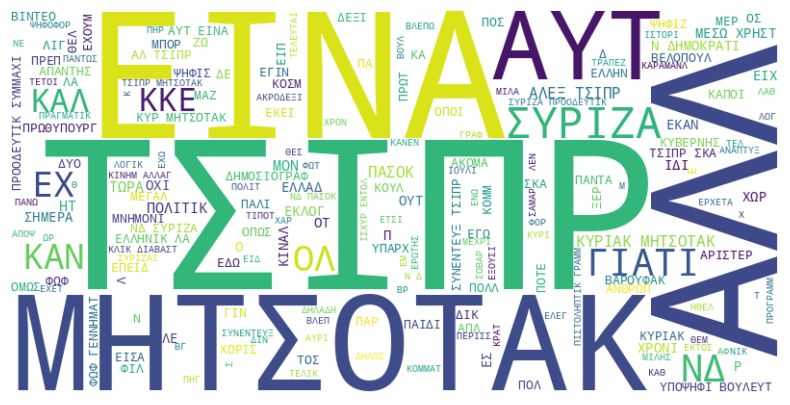

In [13]:
def Word_Cloud(data):
   
    words_list = []
    
    # divide each line into words and store them in a list
    for text in data:
        words = text.split()
        words_list.extend(words)
    
    # connect the words in a text with each other
    String_allWords = ' '.join(words_list)
    
    # create WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(String_allWords)
    
    # visualization
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
        

Word_Cloud(dataframe['Text'])

$\bullet$ $ $ Find the occurrences of each word

In [14]:
# Calculate the occurrences of each word.
bow_vectorizer = CountVectorizer()
bow_xtrain = bow_vectorizer.fit_transform(dataframe_TrainSet['Text'])
b = bow_xtrain.toarray()
k = np.sum(b, axis=0)  

feature_genres = bow_vectorizer.get_feature_names_out()

# Create a dictionary with the name of the genres and the number of their occurrences.
genre_appear = dict(zip(feature_genres, k))

# Sort the dictionary in descending order based on the number of appearances of the species.
sortedDict = dict(sorted(genre_appear.items(), key=lambda item: item[1]))
sortDescOrder = dict(reversed(list(sortedDict.items())))
sortDescOrder

{'τσιπρ': 8631,
 'μητσοτακ': 7886,
 'εινα': 6669,
 'νδ': 5541,
 'συριζα': 4890,
 'αυτ': 4138,
 'αλλ': 3113,
 'εχ': 3100,
 'κκε': 2689,
 'ολ': 2423,
 'κυριακ': 2283,
 'πασοκ': 2055,
 'γιατι': 2015,
 'καν': 1965,
 'κιναλ': 1734,
 'καλ': 1727,
 'πολιτικ': 1629,
 'εκλογ': 1608,
 'αλεξ': 1535,
 'μον': 1518,
 'συνεντευξ': 1461,
 'κυβερνης': 1423,
 'χωρ': 1322,
 'ητ': 1312,
 'ελλαδ': 1266,
 'σκα': 1262,
 'λα': 1177,
 'μερ': 1173,
 'τωρα': 1153,
 'δημοκρατι': 1146,
 'μεγαλ': 1110,
 'ψηφις': 1104,
 'χρονι': 1080,
 'γεννηματ': 1070,
 'ψηφ': 1048,
 'λε': 1033,
 'οχι': 1018,
 'υποψηφι': 1000,
 'νε': 969,
 'εκαν': 956,
 'ειπ': 951,
 'ειχ': 947,
 'βουλευτ': 938,
 'θελ': 905,
 'ελλην': 892,
 'ιδι': 887,
 'μπορ': 858,
 'ελληνικ': 854,
 'φωφ': 848,
 'ος': 834,
 'οτ': 822,
 'μεσω': 815,
 'πολ': 809,
 'ουτ': 791,
 'υπαρχ': 784,
 'σημερα': 784,
 'πρωτ': 775,
 'πρωθυπουργ': 752,
 'βαρουφακ': 742,
 'χρηστ': 739,
 'ες': 734,
 'μνημονι': 730,
 'φορ': 709,
 'εδω': 700,
 'οπως': 699,
 'αριστερ': 698,
 'προεκλογ

$\bullet$ $ $ Find the occurrences of each sentiment **Train & Valid set**

In [15]:
# merge the train and valid set into a dataframe
dataframeTV = pd.concat([dataframe_TrainSet, dataframe_ValidSet])

bow_vectorizer = CountVectorizer(lowercase=False)
bow_xtrain = bow_vectorizer.fit_transform(dataframeTV['Sentiment'])
b = bow_xtrain.toarray()
k = np.sum(b, axis=0)

feature_genres = bow_vectorizer.get_feature_names_out()

# Create a dictionary with the name of the genres and the number of their occurrences.
genre_appear = dict(zip(feature_genres, k))

print(genre_appear)

{'NEGATIVE': 13954, 'NEUTRAL': 13954, 'POSITIVE': 13954}


## Model Creation

#### Word2Vec model 

$ $

$\bullet $  $  $   Build a Word2Vec model

In [16]:
# Splitting text into words and storing them in a list
word_set = []
for col in dataframe.Text:
   word_list = word_tokenize(col)
   word_set.append(word_list)

# Initialization and training of the Word2Vec model
model_w2v = Word2Vec(
    word_set,
    vector_size=100,    # desired no. of features/independent variables
    window = 5,    # context window size
    min_count=1,
    workers = 4   # no.of cores
  )


#  Remove empty word if it exists in the Word2Vec word dictionary.
if '' in model_w2v.wv.index_to_key:
  model_w2v.wv.index_to_key.remove('')

# Save the model
model_w2v.save("greek_word2vec.model")

model_w2v.wv.index_to_key

['ΤΣΙΠΡ',
 'ΜΗΤΣΟΤΑΚ',
 'ΕΙΝΑ',
 'ΝΔ',
 'ΣΥΡΙΖΑ',
 'ΑΥΤ',
 'Ο',
 'ΕΧ',
 'ΑΛΛ',
 'ΚΚΕ',
 'ΟΛ',
 'ΚΥΡΙΑΚ',
 'ΠΑΣΟΚ',
 'ΓΙΑΤΙ',
 'Ν',
 'ΚΑΝ',
 'ΚΑΛ',
 'ΚΙΝΑΛ',
 'ΠΟΛΙΤΙΚ',
 'ΕΚΛΟΓ',
 'ΑΛΕΞ',
 'ΜΟΝ',
 'ΣΥΝΕΝΤΕΥΞ',
 'ΚΥΒΕΡΝΗΣ',
 'ΗΤ',
 'ΧΩΡ',
 'ΕΛΛΑΔ',
 'ΣΚΑ',
 'ΜΕΡ',
 'ΔΗΜΟΚΡΑΤΙ',
 'ΤΩΡΑ',
 'Π',
 'Δ',
 'ΛΑ',
 'ΨΗΦΙΣ',
 'ΜΕΓΑΛ',
 'ΧΡΟΝΙ',
 'ΛΕ',
 'ΓΕΝΝΗΜΑΤ',
 'ΨΗΦ',
 'ΟΧΙ',
 'ΥΠΟΨΗΦΙ',
 'Ρ',
 'ΕΚΑΝ',
 'ΕΙΧ',
 'ΝΕ',
 'ΕΙΠ',
 'ΒΟΥΛΕΥΤ',
 'ΘΕΛ',
 'ΕΛΛΗΝ',
 'ΙΔΙ',
 'ΕΛΛΗΝΙΚ',
 'ΜΠΟΡ',
 'ΟΣ',
 'ΟΤ',
 'ΦΩΦ',
 '–',
 'ΜΕΣΩ',
 'ΠΡΩΤ',
 'ΟΥΤ',
 'ΠΟΛ',
 'ΣΗΜΕΡΑ',
 'ΥΠΑΡΧ',
 'ΒΑΡΟΥΦΑΚ',
 'ΠΡΩΘΥΠΟΥΡΓ',
 'ΜΝΗΜΟΝΙ',
 'ΦΟΡ',
 'ΧΡΗΣΤ',
 'ΕΣ',
 'ΑΡΙΣΤΕΡ',
 'ΟΠΩΣ',
 'ΕΔΩ',
 'ΚΟΥΛ',
 'ΠΡΟΕΚΛΟΓΙΚ',
 'ΑΥΤΟΔΥΝΑΜΙ',
 'ΤΟΣ',
 'ΠΑΡ',
 'ΚΟΜΜ',
 'ΠΡΕΠ',
 'ΟΠΟΙ',
 'ΛΙΓ',
 ';',
 'ΨΗΦΙΖ',
 'ΒΙΝΤΕΟ',
 'ΑΠΛ',
 'ΔΗΜΟΣΙΟΓΡΑΦ',
 'ΙΣΧΥΡ',
 'ΤΕΛΕΥΤΑΙ',
 'ΔΕΞΙ',
 'ΓΙΝ',
 'ΠΑ',
 'ΠΟΣ',
 'ΕΓΩ',
 'ΠΡΟΟΔΕΥΤΙΚ',
 'ΚΑΡΑΜΑΝΛ',
 'ΒΟΥΛ',
 'ΕΠ',
 '/',
 'ΟΜΙΛΙ',
 'ΙΟΥΛΙ',
 'ΑΛΛΑΓ',
 'ΠΡΟΓΡΑΜΜ',
 'ΚΑΠΟΙ',
 'ΜΑΖ',
 'ΒΕΛΟΠΟΥΛ',
 'ΚΟΣΜ',
 'ΠΟΛ

$ $ 

$\bullet $  $  $  Data conversion to vectors

In [17]:
def Vectorize(dataset, model_w2v):

    list_keys = model_w2v.wv.index_to_key
    FeaturesVecs = []
    
    for text in dataset["Text"]:
    
        words = {index: word for index, word in enumerate(text.split(" "))}
        featureVec = np.zeros((len(words), 100))
 
        # for each word in the description, it is checked if it belongs to the model's dictionary. 
        # if yes,the word is added to the featureVec array.
        for index, word in words.items():
            if word in list_keys:
                featureVec[index] = model_w2v.wv[word]

        FeaturesVecs.append(np.mean(featureVec,axis=0))

    return np.array(FeaturesVecs)

In [18]:
# train set
XV_train = Vectorize(dataframe_TrainSet, model_w2v)

# valid set
XV_val = Vectorize(dataframe_ValidSet, model_w2v)

# test set
XV_test = Vectorize(dataframe_TestSet, model_w2v)

####  Recurrent Neural Networks

$ $ 

$\bullet $  $  $ Convert texts into tensors

In [19]:
# convert labels to numerical values
labelencoder = LabelEncoder()

# train set
XT_train = torch.tensor(XV_train, dtype=torch.float, device=device)
YT_train = labelencoder.fit_transform(dataframe_TrainSet['Sentiment'])
YT_train = torch.tensor(YT_train, device=device)

# valid set 
XT_val = torch.tensor(XV_val, dtype=torch.float, device=device)
YT_val = labelencoder.fit_transform(dataframe_ValidSet['Sentiment'])
YT_val = torch.tensor(YT_val, device=device)

# test set 
XT_test = torch.tensor(XV_test, dtype=torch.float, device=device)

In [20]:
import torch.nn as nn

class RNN(nn.Module):
    """
    Wrapper module for RNN, LSTM, GRU cells using pytorch api. The output is fed to a FFN for classification.
    """
    def __init__(self, cell_type, input_size, hidden_size, num_layers, num_heads, dropout, output_size, skip, attention=True):
        super(RNN, self).__init__()

        cells = {
          "LSTM": nn.LSTM,
          "GRU": nn.GRU
        }

        self.cell_type = cell_type
        self.hidden_size = hidden_size*num_heads
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
        self.attention = attention
        self.skipConnections = skip
        
        if self.skipConnections: 
            auxiliary_list = []
            for no_layer in range(num_layers):
                
                if no_layer == 0: temp = input_size
                else: temp = self.hidden_size*2
                
                auxiliary_list.append(
                    cells[cell_type](
                        input_size=temp,
                        hidden_size=self.hidden_size,
                        num_layers=1, 
                        bidirectional=True
                    )
                )
            
            self.rnn = nn.ModuleList(auxiliary_list)
        
        else:
            self.rnn = cells[cell_type](
                        input_size=input_size,
                        hidden_size=self.hidden_size,
                        num_layers=num_layers, 
                        bidirectional=True
                    ) 

        if self.attention:
            self.multAttention = nn.MultiheadAttention(self.hidden_size * 2, num_heads, dropout=dropout)
        
        self.out = nn.Linear(self.hidden_size*2, output_size)

        
    def forward(self, x):
        
        
        if self.skipConnections: 
            
            c=0
            out, _ = self.rnn[0](x) 
            for rnn_layer in self.rnn:
                
                if c == 0: c=1; continue
                    
                p_out = out
                out = self.dropout(out)  # Apply dropout
                out, _ = rnn_layer(out) 
                out_skip = out + p_out  # Apply skip connection
                out = torch.relu(out_skip)
        else:
            out, _ = self.rnn(x)
    
        if self.attention: 
            attn_output, _ = self.multAttention(out, out, out)
            out = out + attn_output
        
        out = self.out(out)
        
        # Final output
        return out


**Definition of the training process**

In [21]:
def network_training(dataloader, model, loss_fn, optimizer, device, epoch, clip, display=False):

    size = len(dataloader.dataset)
    
    model.train()

    # lab 7
    for batch, (X, y) in enumerate(dataloader):
        # if using gpu dont forget to move the data there
        
        X = X.to(device)
        y = y.to(device)
     
        # Compute prediction and loss
        pred = model(X) ## For each input batch
        
        loss = loss_fn(pred, y) ##compute loss

        # Backpropagation
        optimizer.zero_grad()     ##find gradients
        loss.backward()     ##bacvk propagate loss
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()    ##optimization
        
        # Print loss statistics
        if display:
            if batch % 30 == 0:
                current = batch * len(X)
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Samples: {current}/{size}")

    return model

In [22]:
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
# https://eclass.uoa.gr/modules/announcements/index.php?course=DI499&an_id=469014
from sklearn.metrics import f1_score

def test_loop(dataloader, model, loss_fn, display=False):

    all_y = []
    all_preds = []
    correct = 0
    losses = []

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():

        for x_batch, y_batch in dataloader:

            all_y.append(y_batch.cpu())

            pred = model(x_batch)

           
            loss = loss_fn(pred, y_batch).item()
            losses.append(loss) 
            
            correct += torch.sum(torch.eq(pred.argmax(1), y_batch)).float().item()

            all_preds.append(torch.argmax(pred, dim=1).squeeze())
            

    summary = sum(losses)
    summary /= len(dataloader.dataset)
    correct /= len(dataloader.dataset)
    
    if display:
        print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {summary:>8f} \n")
    
    all_y = torch.cat(all_y)
    all_preds = torch.cat(all_preds)

    f1Score = f1_score(all_y, all_preds, average='macro')
    
    return f1Score

In [23]:
#Initialise dataloader
train_dataset = torch.utils.data.TensorDataset(XT_train, YT_train) #class to represent the data as list of tensors. x=input_features, y=labels
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

#Initialise dataloader
valid_dataset = torch.utils.data.TensorDataset(XT_val, YT_val) #class to represent the data as list of tensors. x=input_features, y=labels
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)


In [24]:
import optuna

# 1. Define an objective function to be maximized.
def objective(trial):

    cell_type = trial.suggest_categorical("cell_type", ['LSTM', 'GRU'])
    num_layers = trial.suggest_int("num_layers", 2, 8)
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    dropout = trial.suggest_float("dropout", 0.1, 0.9, step = 0.05)
    num_heads = trial.suggest_int("num_heads", 1, 5)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, step = 0.0005)
    skipConnections = trial.suggest_categorical('skipConnections', [True, False])
    clip = trial.suggest_int('clip', 1, 5)

 
    #Initialise model, loss, optimizer
    model = RNN(cell_type=cell_type, 
                input_size=XT_train.shape[1], 
                hidden_size=hidden_size, 
                num_layers=num_layers, 
                num_heads=num_heads, 
                dropout=dropout, 
                output_size=3,
                skip=skipConnections
               )


    num_epochs = 1   # define number of epochs

    for epoch in range(num_epochs):
    
        
        loss_fn = nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
     
       # Network training
        model.train()
        network_training(train_dataloader, model, loss_fn, optimizer, device, epoch, clip)
        
        # Evaluation function
        model.eval()
        f1_macro_avg = test_loop(valid_dataloader, model, loss_fn)
    
    
    return f1_macro_avg

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-02-13 01:32:44,676] A new study created in memory with name: no-name-f72598a1-a3b9-4fa3-915f-bf0a136db49b
[I 2024-02-13 01:34:01,954] Trial 0 finished with value: 0.16666666666666666 and parameters: {'cell_type': 'LSTM', 'num_layers': 8, 'hidden_size': 57, 'dropout': 0.4, 'num_heads': 4, 'learning_rate': 0.07100000000000001, 'skipConnections': True, 'clip': 4}. Best is trial 0 with value: 0.16666666666666666.
[I 2024-02-13 01:35:19,628] Trial 1 finished with value: 0.16666666666666666 and parameters: {'cell_type': 'LSTM', 'num_layers': 8, 'hidden_size': 76, 'dropout': 0.7000000000000001, 'num_heads': 3, 'learning_rate': 0.0655, 'skipConnections': False, 'clip': 4}. Best is trial 0 with value: 0.16666666666666666.
[I 2024-02-13 01:38:23,069] Trial 2 finished with value: 0.16666666666666666 and parameters: {'cell_type': 'GRU', 'num_layers': 6, 'hidden_size': 40, 'dropout': 0.55, 'num_heads': 5, 'learning_rate': 0.056, 'skipConnections': False, 'clip': 4}. Best is trial 0 with val

#### Plots

In [25]:
optuna.visualization.plot_slice(study)

In [26]:
optuna.visualization.plot_optimization_history(study)

In [27]:
optuna.visualization.plot_parallel_coordinate(study)

#### Best Parameters

In [28]:
best_params = study.best_params
print(best_params)

{'cell_type': 'LSTM', 'num_layers': 3, 'hidden_size': 42, 'dropout': 0.65, 'num_heads': 1, 'learning_rate': 0.0045000000000000005, 'skipConnections': True, 'clip': 5}


In [29]:
#Initialise model, loss, optimizer
model = RNN(cell_type=best_params['cell_type'], 
            input_size=XT_train.shape[1], 
            hidden_size=best_params['hidden_size'], 
            num_layers=best_params['num_layers'],
            num_heads=best_params['num_heads'],
            dropout=best_params['dropout'], 
            output_size=3,
            skip=best_params['skipConnections'],
           )

best_epoch = 0
best_f1 = 0.0
best_model = model

for epoch in range(50):

    print(f"\n\n-- {epoch}. Epoch--\n")
    
    loss_fn = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr = best_params['learning_rate'])
     
    # Network training
    model.train()
    model = network_training(train_dataloader, model, loss_fn, optimizer, device, epoch, best_params['clip'], True)
        
    # Evaluation function
    model.eval()
    f1_macro_avg = test_loop(valid_dataloader, model, loss_fn, True)
    
    if f1_macro_avg >= best_f1:
        best_f1 = f1_macro_avg
        best_epoch = epoch
        best_model = model

print("Done!")



-- 0. Epoch--

Epoch 0, Loss: 1.0990, Samples: 0/36630
Epoch 0, Loss: 1.0863, Samples: 1920/36630
Epoch 0, Loss: 1.1033, Samples: 3840/36630
Epoch 0, Loss: 1.0892, Samples: 5760/36630
Epoch 0, Loss: 1.0968, Samples: 7680/36630
Epoch 0, Loss: 1.0779, Samples: 9600/36630
Epoch 0, Loss: 1.1117, Samples: 11520/36630
Epoch 0, Loss: 1.0811, Samples: 13440/36630
Epoch 0, Loss: 1.0924, Samples: 15360/36630
Epoch 0, Loss: 1.0907, Samples: 17280/36630
Epoch 0, Loss: 1.0742, Samples: 19200/36630
Epoch 0, Loss: 1.0873, Samples: 21120/36630
Epoch 0, Loss: 1.0856, Samples: 23040/36630
Epoch 0, Loss: 1.0956, Samples: 24960/36630
Epoch 0, Loss: 1.1006, Samples: 26880/36630
Epoch 0, Loss: 1.1076, Samples: 28800/36630
Epoch 0, Loss: 1.0703, Samples: 30720/36630
Epoch 0, Loss: 1.0845, Samples: 32640/36630
Epoch 0, Loss: 1.1175, Samples: 34560/36630
Epoch 0, Loss: 1.0815, Samples: 36480/36630
Accuracy: 39.0%, Avg loss: 0.017021 



-- 1. Epoch--

Epoch 1, Loss: 1.0877, Samples: 0/36630
Epoch 1, Loss: 1.

**Run a model with the best parameters**


The best performance of the f1-score metric for validation set is 0.39937196046789336 at epoch no.47

Accuracy: 38.9%, Avg loss: 0.016832 

              precision    recall  f1-score   support

           0       0.37      0.66      0.47      1744
           1       0.40      0.33      0.36      1744
           2       0.48      0.20      0.28      1744

    accuracy                           0.39      5232
   macro avg       0.42      0.39      0.37      5232
weighted avg       0.42      0.39      0.37      5232

Done!



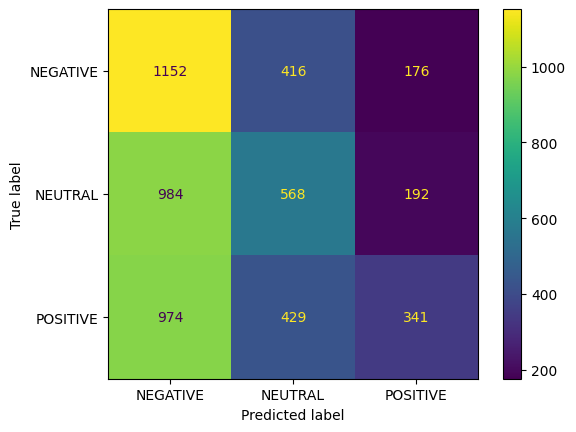

In [30]:
print(f"\nThe best performance of the f1-score metric for validation set is {best_f1} at epoch no.{best_epoch}\n")

test_loop(valid_dataloader, best_model, loss_fn, True)

predicted = best_model(XT_val)
predicted = torch.argmax(predicted, dim=1)
Y_val = labelencoder.fit_transform(dataframe_ValidSet['Sentiment'])
print(classification_report(Y_val, predicted.to('cpu')))

cm = metrics.confusion_matrix(Y_val, predicted)
labels = list(genre_appear.keys())
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels).plot()

print("Done!\n")

Learning-curves

F1 Score Train: 0.16666666666666666
F1 Score Validation: 0.16666666666666666
F1 Score Train: 0.21169173338965624
F1 Score Validation: 0.21265034435810956
F1 Score Train: 0.1709654971822583
F1 Score Validation: 0.16666666666666666
F1 Score Train: 0.31066825969445633
F1 Score Validation: 0.31336070407399874
F1 Score Train: 0.34487163094162254
F1 Score Validation: 0.3560174659142223
F1 Score Train: 0.30042552419480784
F1 Score Validation: 0.3094141559060193
F1 Score Train: 0.2906806292989292
F1 Score Validation: 0.28997795853621705
F1 Score Train: 0.3243155765502356
F1 Score Validation: 0.33677961632781805
F1 Score Train: 0.33182869060316056
F1 Score Validation: 0.3375885387705719
F1 Score Train: 0.3252969197713441
F1 Score Validation: 0.34612186856882027


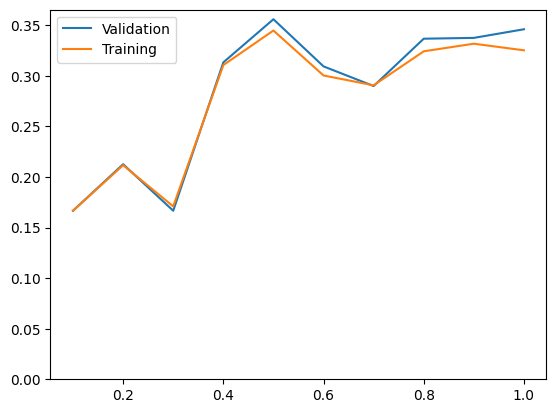

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix

list_f1=[]
list_f1_train=[]
list_sample_size=[]

for times in range(10):
  # training
  #
    X, X_unused, y, y_unused = train_test_split(XT_train, YT_train, test_size=1 - (times * 0.1 + 0.001))
    
    #Initialise dataloader
    train_dataset = torch.utils.data.TensorDataset(X, y) #class to represent the data as list of tensors. x=input_features, y=labels
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

    #Initialise dataloader
    valid_dataset = torch.utils.data.TensorDataset(X_unused, y_unused) #class to represent the data as list of tensors. x=input_features, y=labels
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)


    #Initialise model, loss, optimizer
    model = RNN(cell_type=best_params['cell_type'], 
                input_size=XT_train.shape[1], 
                hidden_size=best_params['hidden_size'], 
                num_layers=best_params['num_layers'],
                num_heads=best_params['num_heads'],
                dropout=best_params['dropout'], 
                output_size=3,
                skip=best_params['skipConnections'],
               )

    loss_fn = nn.CrossEntropyLoss()
                    
    optimizer = torch.optim.Adam(model.parameters(), lr = best_params['learning_rate'])

                        
    # Network training
    network_training(train_dataloader, model, loss_fn, optimizer, device, times, best_params['clip'])

    results_train = model.forward(X)
    results_train = torch.argmax(results_train, dim=1)
    results_train = results_train.to('cpu')

    # validation
    #
    results = model.forward(XT_val)
    results = torch.argmax(results, dim=1)
    results = results.to('cpu')

    # score
    #
    f1_train = f1_score(y, results_train, average="weighted")
    print("F1 Score Train: " + str(f1_train))

    f1 = f1_score(Y_val, results, average="weighted")
    print("F1 Score Validation: " + str(f1))

    list_f1.append(f1)
    list_f1_train.append(f1_train)
    list_sample_size.append((times * 0.1 + 0.1))

plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])

ROC curves

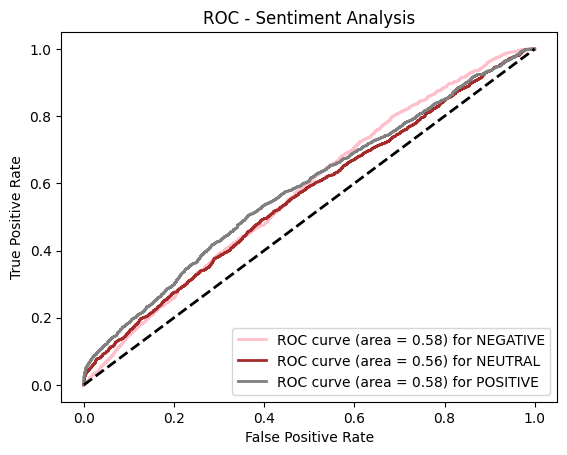

In [32]:
# https://stackoverflow.com/questions/71788074/how-to-get-the-roc-curve-of-a-neural-network
predicted_prob = best_model(XT_val).cpu()
predicted_prob = predicted_prob.squeeze(-1).detach().numpy()


# calculation of ROC curve for each emotion category
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_val, predicted_prob[:, i], pos_label = i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# visualization of ROC curve
plt.figure()
colors = ['pink', 'brown', 'grey']
labels = list(genre_appear.keys())

for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for {labels[i]}')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Sentiment Analysis')
plt.legend(loc="lower right")
plt.show()

#### Test Set

In [33]:
predicted = best_model.forward(XT_test)
predicted = torch.argmax(predicted, dim=1)

df_subm = dataframe_TestSet[['New_ID']].copy()
df_subm['Predicted'] = predicted.to(device)
df_subm['Predicted'] = df_subm['Predicted'].replace({0: labels[0], 1: labels[1], 2: labels[2]})

df_subm = df_subm.rename(columns={"New_ID": "Id", "Predicted": "Predicted"})

df_subm = df_subm.set_index('Id')

df_subm.to_csv('/kaggle/working/submission.csv')

df_subm

,Predicted
Id,
1,NEGATIVE
2,POSITIVE
3,POSITIVE
4,POSITIVE
5,NEGATIVE
...,...
10466,NEGATIVE
10467,NEGATIVE
10468,NEGATIVE
